## CO₂ Emissions Per Capita Prediction (India)

Goal:
Predict India’s CO₂ emissions per capita for a given year using historical
energy and economic trends.

Approach:
- Use year as the only external input
- Forecast key energy drivers from historical data
- Use predicted drivers to estimate CO₂ emissions per capita

Scope:
- Focused purely on prediction accuracy
- No policy attribution or causal claims

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Load Dataset

In [93]:
co2_df = pd.read_csv(r"C:\Users\NIMISH\Desktop\carbon_emission_prediction\data\owid-co2-data.csv")
energy_df = pd.read_csv(r"C:\Users\NIMISH\Desktop\carbon_emission_prediction\data\owid-energy-data.csv")

print(co2_df.shape, energy_df.shape)

(50411, 79) (23195, 130)


### Filter India from dataset and feature selection

In [94]:
co2_india = co2_df[co2_df["country"] == "India"]
energy_india = energy_df[energy_df["country"] == "India"]

In [95]:
co2_cols = [
    "year",
    "co2_per_capita"
]

energy_cols = [
    "year",
    "energy_per_capita",
    "fossil_energy_per_capita",
    "renewables_share_energy",
    "energy_per_gdp"
]

co2_india = co2_india[co2_cols]
energy_india = energy_india[energy_cols]

In [96]:
model_df = pd.merge(co2_india, energy_india, on="year", how="inner")
model_df = model_df.dropna().reset_index(drop=True)

model_df.head()

,year,co2_per_capita,energy_per_capita,fossil_energy_per_capita,renewables_share_energy,energy_per_gdp
0,1965,0.314,1263.825,1148.192,8.643,1.039
1,1966,0.318,1274.940,1156.744,8.758,1.062
2,1967,0.312,1286.993,1157.539,9.507,1.012
3,1968,0.333,1346.781,1200.554,10.267,1.054
4,1969,0.332,1461.818,1299.008,10.283,1.095


In [97]:
model_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      58 non-null     int64  
 1   co2_per_capita            58 non-null     float64
 2   energy_per_capita         58 non-null     float64
 3   fossil_energy_per_capita  58 non-null     float64
 4   renewables_share_energy   58 non-null     float64
 5   energy_per_gdp            58 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 2.8 KB


### Driver Forecasting Models

1. Energy Per Capita

In [98]:
X_year = model_df[["year"]]

energy_pc_model = LinearRegression()
energy_pc_model.fit(X_year, model_df["energy_per_capita"])

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


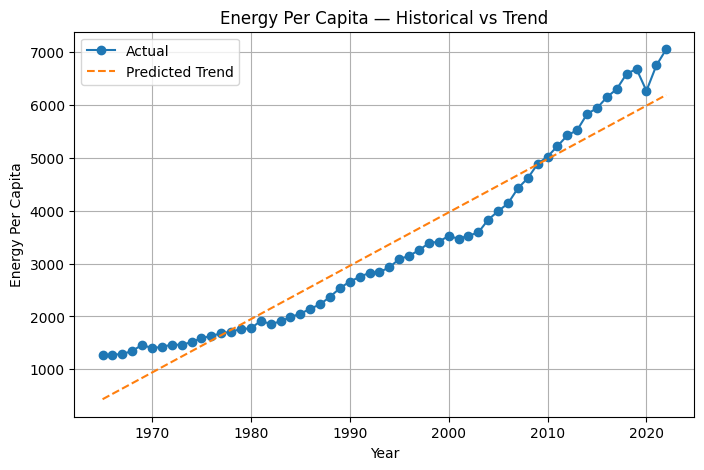

In [99]:
plt.figure(figsize=(8,5))

# Historical data
plt.plot(
    model_df["year"],
    model_df["energy_per_capita"],
    label="Actual",
    marker="o"
)

# Model prediction (trend line)
plt.plot(
    model_df["year"],
    energy_pc_model.predict(X_year),
    linestyle="--",
    label="Predicted Trend"
)

plt.xlabel("Year")
plt.ylabel("Energy Per Capita")
plt.title("Energy Per Capita — Historical vs Trend")
plt.legend()
plt.grid(True)
plt.show()


2. Fossil Energy Per Capita

In [100]:
fossil_pc_model = LinearRegression()
fossil_pc_model.fit(X_year, model_df["fossil_energy_per_capita"])

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


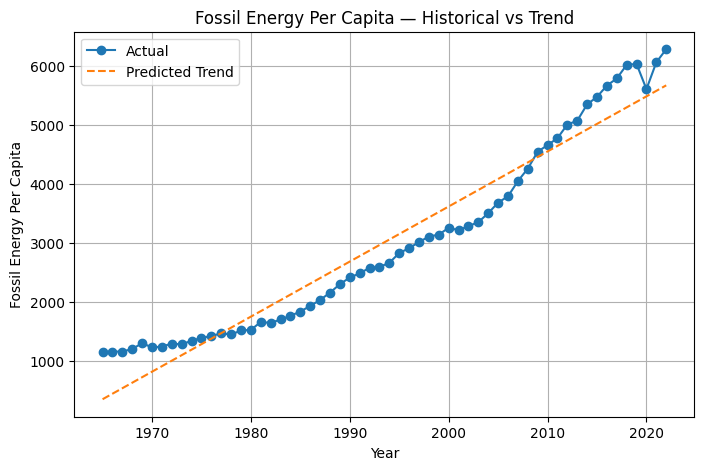

In [101]:
plt.figure(figsize=(8,5))

plt.plot(
    model_df["year"],
    model_df["fossil_energy_per_capita"],
    label="Actual",
    marker="o"
)

plt.plot(
    model_df["year"],
    fossil_pc_model.predict(X_year),
    linestyle="--",
    label="Predicted Trend"
)

plt.xlabel("Year")
plt.ylabel("Fossil Energy Per Capita")
plt.title("Fossil Energy Per Capita — Historical vs Trend")
plt.legend()
plt.grid(True)
plt.show()


3. Energy Per GDP

In [102]:
energy_gdp_model = LinearRegression()
energy_gdp_model.fit(X_year, model_df["energy_per_gdp"])

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


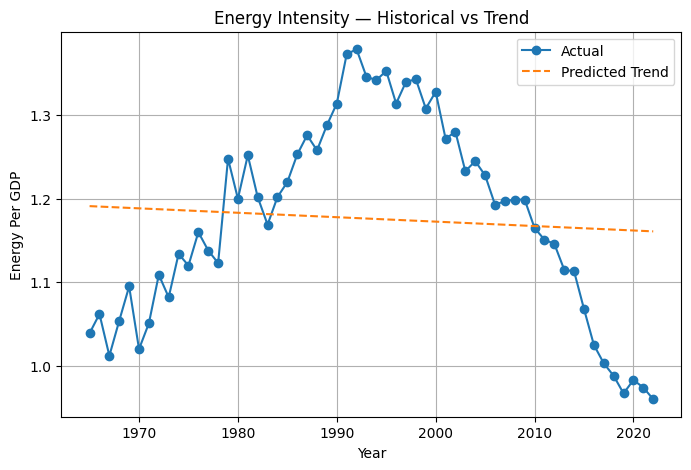

In [103]:
plt.figure(figsize=(8,5))

plt.plot(
    model_df["year"],
    model_df["energy_per_gdp"],
    label="Actual",
    marker="o"
)

plt.plot(
    model_df["year"],
    energy_gdp_model.predict(X_year),
    linestyle="--",
    label="Predicted Trend"
)

plt.xlabel("Year")
plt.ylabel("Energy Per GDP")
plt.title("Energy Intensity — Historical vs Trend")
plt.legend()
plt.grid(True)
plt.show()


4. Renewables Share Energy (Recent-Window Model)

In [104]:
RECENT_START_YEAR = 2015

renew_df = model_df[["year", "renewables_share_energy"]]
renew_recent = renew_df[renew_df["year"] >= RECENT_START_YEAR]

X_renew = renew_recent[["year"]]
y_renew = renew_recent["renewables_share_energy"]

renewables_model = LinearRegression()
renewables_model.fit(X_renew, y_renew)

renewables_model.coef_

array([0.476])

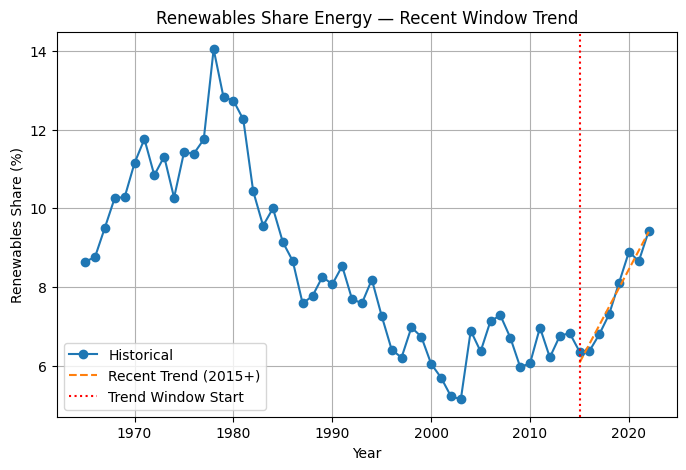

In [105]:
plt.figure(figsize=(8,5))

# Historical data
plt.plot(
    model_df["year"],
    model_df["renewables_share_energy"],
    label="Historical",
    marker="o"
)

# Recent window fit
plt.plot(
    renew_recent["year"],
    renewables_model.predict(renew_recent[["year"]]),
    linestyle="--",
    label="Recent Trend (2015+)"
)

# Cutoff line
plt.axvline(
    x=RECENT_START_YEAR,
    color="red",
    linestyle=":",
    label="Trend Window Start"
)

plt.xlabel("Year")
plt.ylabel("Renewables Share (%)")
plt.title("Renewables Share Energy — Recent Window Trend")
plt.legend()
plt.grid(True)
plt.show()


In [106]:
features = [
    "energy_per_capita",
    "fossil_energy_per_capita",
    "renewables_share_energy",
    "energy_per_gdp"
]

X = model_df[features]
y = model_df["co2_per_capita"]


In [107]:
split_idx = int(len(model_df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

X_train.shape, X_test.shape


((46, 4), (12, 4))

In [108]:
co2_model = ElasticNet(
    alpha=0.0005,
    l1_ratio=0.2,
    random_state=42
)

co2_model.fit(X_train, y_train)


c:\Users\NIMISH\Desktop\carbon_emission_prediction\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.529e-03, tolerance: 4.138e-04
  model = cd_fast.enet_coordinate_descent(


,"alpha alpha: float, default=1.0Constant that multiplies the penalty terms. Defaults to 1.0.See the notes for the exact mathematical meaning of thisparameter. ``alpha = 0`` is equivalent to an ordinary least square,solved by the :class:`LinearRegression` object. For numericalreasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.Given this, you should use the :class:`LinearRegression` object.",0.0005
,"l1_ratio l1_ratio: float, default=0.5The ElasticNet mixing parameter, with ``0 <= l1_ratio <= 1``. For``l1_ratio = 0`` the penalty is an L2 penalty. ``For l1_ratio = 1`` itis an L1 penalty. For ``0 < l1_ratio < 1``, the penalty is acombination of L1 and L2.",0.2
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If ``False``, thedata is assumed to be already centered.",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.Check :ref:`an example on how to use a precomputed Gram Matrix in ElasticNet`for details.",False
,"max_iter max_iter: int, default=1000The maximum number of iterations.",1000
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-4The tolerance for the optimization: if the updates are smaller or equal to``tol``, the optimization code checks the dual gap for optimality and continuesuntil it is smaller or equal to ``tol``, see Notes below.",0.0001
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fit asinitialization, otherwise, just erase the previous solution.See :term:`the Glossary `.",False
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.",False
,"random_state random_state: int, RandomState instance, default=NoneThe seed of the pseudo random number generator that selects a randomfeature to update. Used when ``selection`` == 'random'.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"selection selection: {'cyclic', 'random'}, default='cyclic'If set to 'random', a random coefficient is updated every iterationrather than looping over features sequentially by default. This(setting to 'random') often leads to significantly faster convergenceespecially when tol is higher than 1e-4.",'cyclic'


In [109]:
y_pred = co2_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE :", mae)
print("MSE :", mse)
print("RMSE:", rmse)


MAE : 0.07310060647618007
MSE : 0.006083612521170484
RMSE: 0.07799751612180021


In [110]:
def predict_drivers(year):
    return pd.DataFrame([{
        "energy_per_capita": energy_pc_model.predict([[year]])[0],
        "fossil_energy_per_capita": fossil_pc_model.predict([[year]])[0],
        "renewables_share_energy": renewables_model.predict([[year]])[0],
        "energy_per_gdp": energy_gdp_model.predict([[year]])[0]
    }])


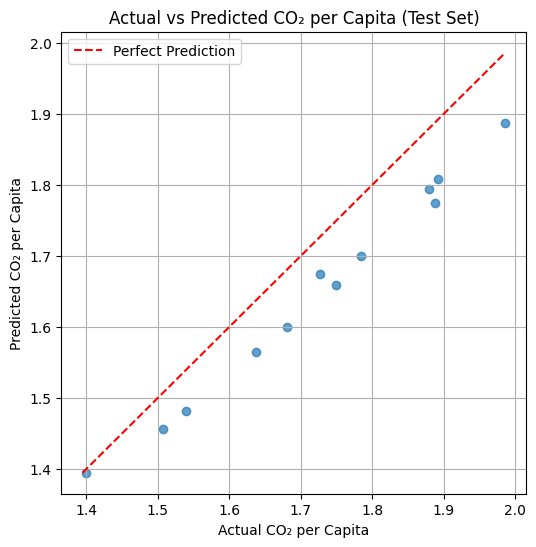

In [111]:
plt.figure(figsize=(6,6))

plt.scatter(
    y_test,
    y_pred,
    alpha=0.7
)

# Perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    linestyle="--",
    color="red",
    label="Perfect Prediction"
)

plt.xlabel("Actual CO₂ per Capita")
plt.ylabel("Predicted CO₂ per Capita")
plt.title("Actual vs Predicted CO₂ per Capita (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


In [112]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = co2_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE :", mae)
print("MSE :", mse)
print("RMSE:", rmse)


MAE : 0.07310060647618007
MSE : 0.006083612521170484
RMSE: 0.07799751612180021


In [113]:
import joblib

joblib.dump(co2_model, "co2_model.pkl")
joblib.dump(
    {
        "energy_per_capita": energy_pc_model,
        "fossil_energy_per_capita": fossil_pc_model,
        "renewables_share_energy": renewables_model,
        "energy_per_gdp": energy_gdp_model
    },
    "driver_models.pkl"
)


['driver_models.pkl']

In [114]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print("R²:", r2)


R²: 0.790040867520777
